In [1]:
# Imports 
import gym
import numpy as np
from gym.spaces import Box
import gfootball.env as football_env
from gfootball.env import create_environment as _create_env
from gym.wrappers import FrameStack
import matplotlib.pyplot as plt
import torch

Get all the scenerios available

In [2]:
from gfootball.env.scenario_builder import all_scenarios
print(all_scenarios())

['11_vs_11_competition', '11_vs_11_easy_stochastic', '11_vs_11_hard_stochastic', '11_vs_11_kaggle', '11_vs_11_stochastic', '1_vs_1_easy', '5_vs_5', 'academy_3_vs_1_with_keeper', 'academy_corner', 'academy_counterattack_easy', 'academy_counterattack_hard', 'academy_empty_goal', 'academy_empty_goal_close', 'academy_pass_and_shoot_with_keeper', 'academy_run_pass_and_shoot_with_keeper', 'academy_run_to_score', 'academy_run_to_score_with_keeper', 'academy_single_goal_versus_lazy', 'test_example_multiagent', 'tests']


We will use the stacked extracted representation of the game as it gave the best results in the original paper. (We will have to transpose the observation before feeding it to pytorch) 

In [3]:
env = football_env.create_environment(
    env_name='11_vs_11_stochastic',
    representation='extracted',
    stacked=True,
    number_of_left_players_agent_controls=1,
    render=False
)
print(env.observation_space.shape)  # -> (72, 96, 16)
print(env.action_space)  # -> Discrete(19)
print(env.reward_range)

(72, 96, 16)
Discrete(19)
(-inf, inf)


Lets display what our observation looks like

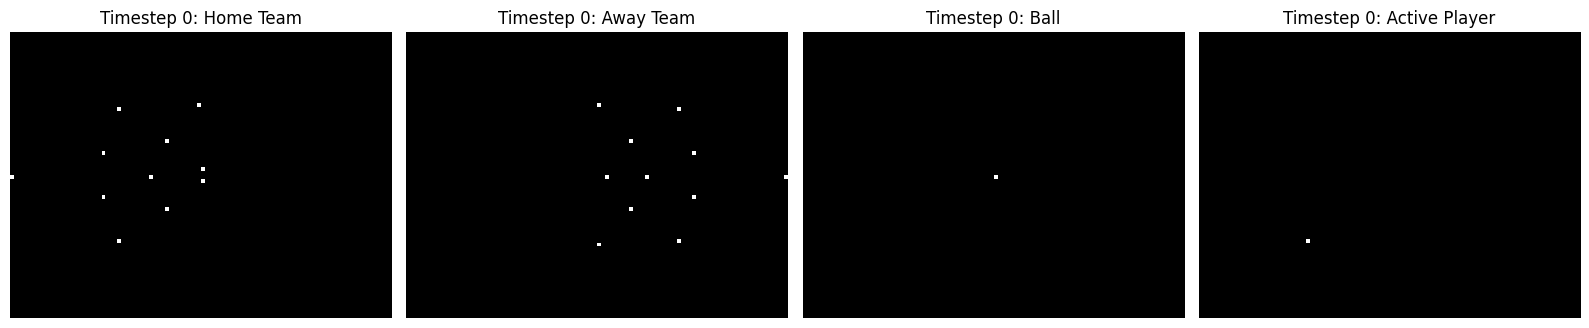

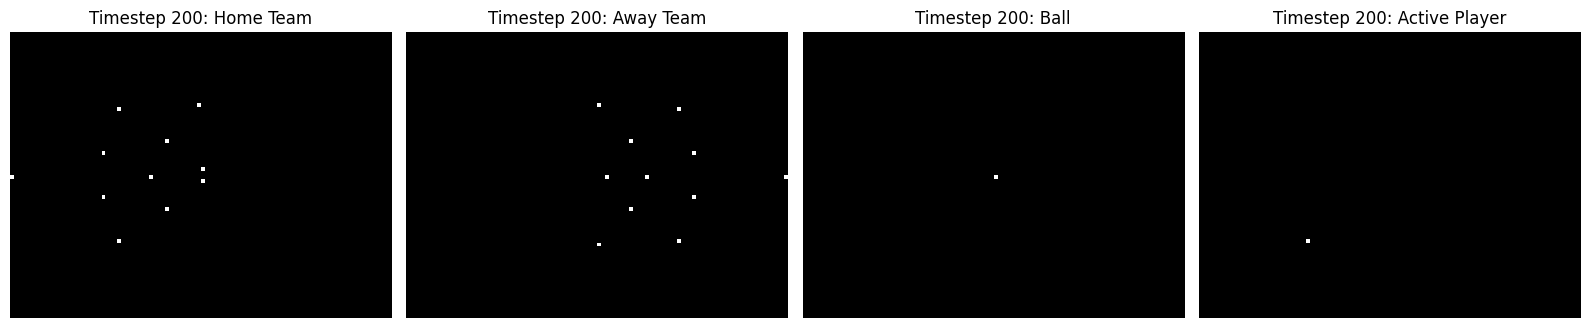

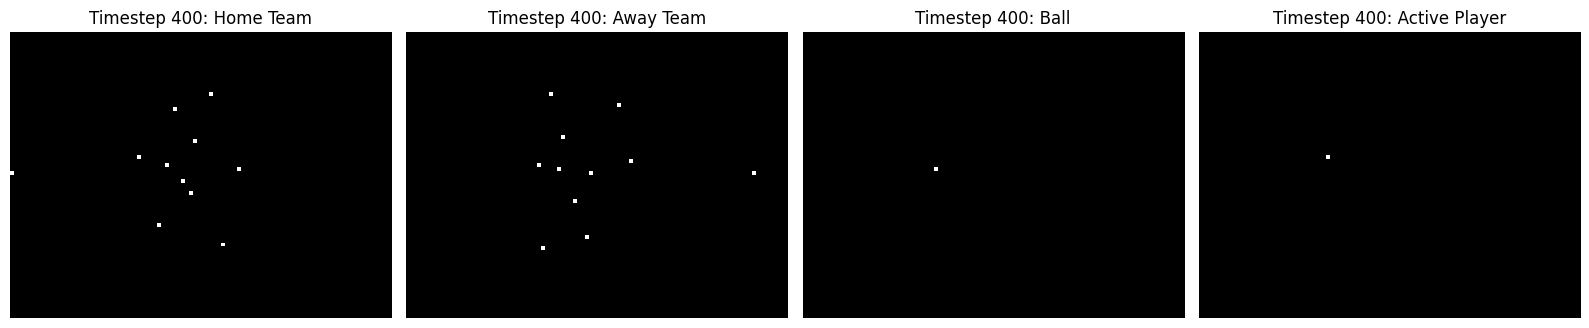

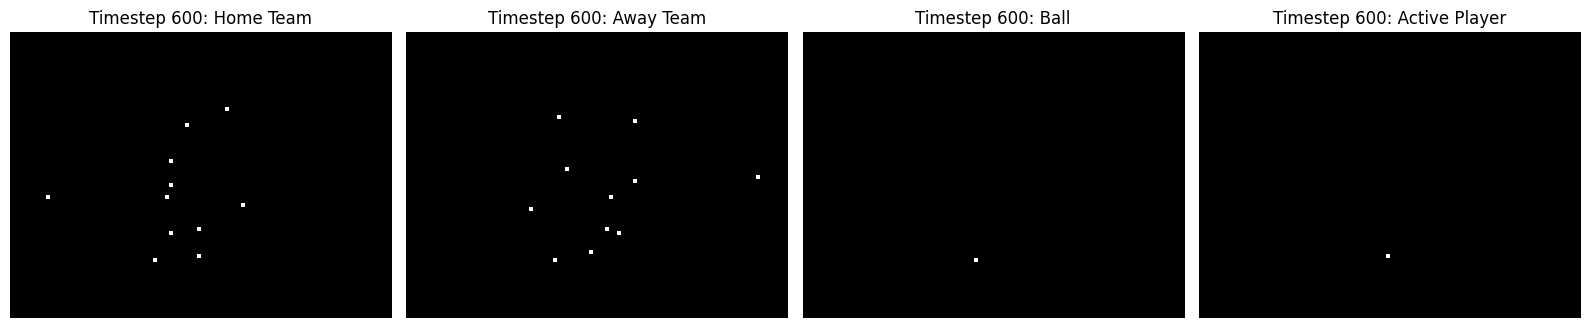

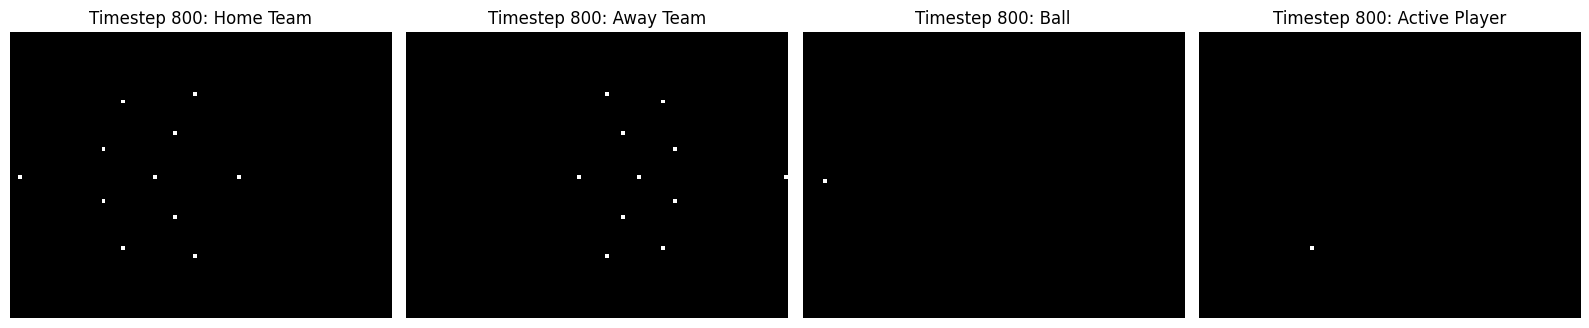

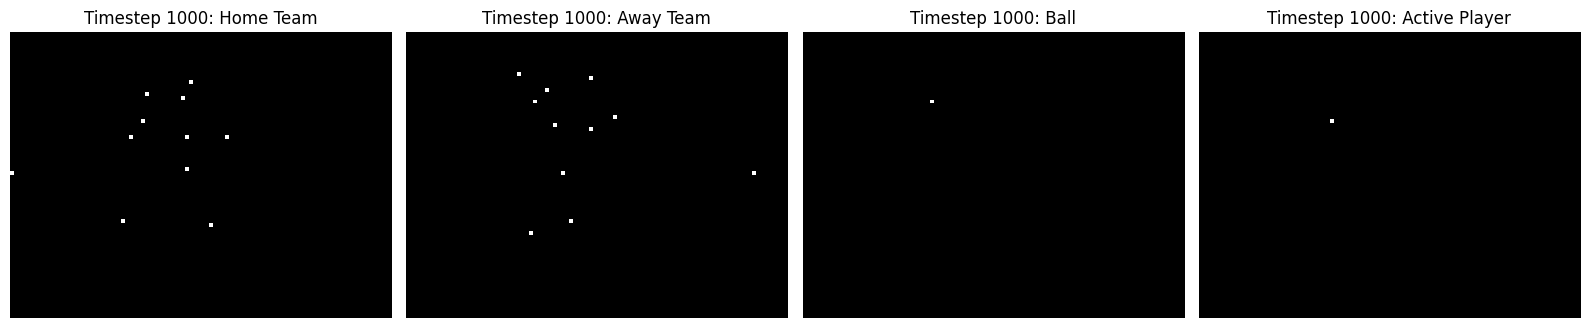

In [4]:
# Reset and collect the first frame (t=0)
frames = []
obs = env.reset()  # obs.shape == (72, 96, 16)
frames.append(obs)

# 3) Step and collect every 10th stacked frame
for step in range(1000):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    

    if step % 200 == 0:
        # reshape from (72,96,16) → (H=72, W=96, stack=4, channels=4,)
        obs4 = obs.reshape(72, 96, 4, 4)

        # iterate over the 4 stacked frames
        for k in range(obs4.shape[2]):
            # obs4[k] has shape (72,96,4): (H, W, channels)

            frame = obs4[:, :, k, :]  # shape: (72, 96, 4)
            frames.append(frame)
            break


    if done:
        break
# 4) Visualize
plane_names = ['Home Team', 'Away Team', 'Ball', 'Active Player']

for t, frame in enumerate(frames):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i, ax in enumerate(axes):
        ax.imshow(frame[:, :, i], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'Timestep {t*200}: {plane_names[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
# TODO 1: Reward Engineering
# TODO 2: Action Blocking
# TODO 3: Create your CNN-PPO 
# TODO 4: Train you agent on the easiest academy scenerio
# TODO 5: Figure out if you can visualize your agent with pixels after training it on the extracted representation

dPPO architecture used in the paper 

input: (72, 96, 16) (they have used tensorflow, we will transpose this to (16, 72, 96) to use pytorch) <br>
x4: 

# Actor Critic Policy and Value Network

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import gym
import torch.nn.functional as F
from collections import deque
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        residual = x
        out = self.relu(x)
        out = self.conv1(out)
        out = self.relu(out)
        out = self.conv2(out+residual)
        return out
    
class ActorCritic(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        C,H,W = input_shape
        self.num_actions = num_actions
        self.relu = nn.ReLU()
        
        # first group of layers
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1)
        self.max1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.res1a = ResidualBlock(16)
        self.res1b =ResidualBlock(16)

        # Second stage: 16 → 32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.max2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.res2a = ResidualBlock(32)
        self.res2b = ResidualBlock(32)

        # Third stage
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.max3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.res3a = ResidualBlock(32)
        self.res3b = ResidualBlock(32)

        # Fourth stage
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.max4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.res4a = ResidualBlock(32)
        self.res4b = ResidualBlock(32)

        # Dynamically compute FC input size
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            dummy = self.forward_conv(dummy)
            self.flattened_size = dummy.view(1, -1).size(1)

        self.fc = nn.Linear(self.flattened_size, 256)
        self.policy = nn.Linear(256, num_actions)
        self.value = nn.Linear(256, 1)

    def forward_conv(self, x):
        x = self.conv1(x)
        x = self.max1(x)
        x = self.res1a(x)
        x = self.res1b(x)

        x = self.conv2(x)
        x = self.max2(x)
        x = self.res2a(x)
        x = self.res2b(x)

        x = self.conv3(x)
        x = self.max3(x)
        x = self.res3a(x)
        x = self.res3b(x)

        x = self.conv4(x)
        x = self.max4(x)
        x = self.res4a(x)
        x = self.res4b(x)
        return x
    
    def forward(self,x):
        x = x /255
        x = self.forward_conv(x)
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc(x))
        return self.policy(x), self.value(x)
    
    

# PPO Agent

In [ ]:
# PPO hyperparams
# ------------------------------------------------------------------
action_repetitions = 1          # Number of times each action is repeated (usually 1 for PPO)
clip_range = 0.08              # PPO clipping range for the objective function
gamma = 0.993                   # Discount factor for future rewards
entropy_coef = 0.003            # Coefficient for the entropy bonus (encourages exploration)
gae_lambda = 0.95               # GAE lambda parameter for bias-variance tradeoff
grad_norm_clip = 0.64           # Maximum norm for gradient clipping (helps stabilize training)
learning_rate = 0.000343        # Learning rate for the optimizer
num_actors = 16                 # Number of parallel environments (actors)
optimizer = "Adam"              # Optimizer used (typically Adam in PPO)
train_epochs = 4                # Number of training epochs per update
train_minibatches = 8           # Number of mini-batches per PPO update
unroll_length = 512            # Number of steps before each PPO update (n-step)
value_function_coef = 0.5       # Coefficient for the value function loss term


# Early‑stopping & per‑stage limits
# ------------------------------------------------------------------
MAX_STAGE_STEPS     = 5_000_000     # max env steps per academy stage
EARLY_STOP_EPISODES = 200          # sliding window length
EARLY_STOP_REWARD   = 1.7         # threshold on mean episodic return
# ------------------------------------------------------------------

In [ ]:
import os
from collections import deque
import matplotlib.pyplot as plt
from torch.distributions import Categorical
from gym.vector.async_vector_env import AsyncVectorEnv  # Use Async for true concurrency
from tqdm import tqdm

# Curriculum
curriculum = [
    'academy_empty_goal_close',
    'academy_empty_goal',
    'academy_run_to_score',
    'academy_run_to_score_with_keeper',
    'academy_pass_and_shoot_with_keeper',
    'academy_run_pass_and_shoot_with_keeper',
    'academy_3_vs_1_with_keeper',
    'academy_corner',
    'academy_counterattack_easy',
    'academy_counterattack_hard',
    'academy_single_goal_versus_lazy',
    '1_vs_1_easy', 
    '5_vs_5'
]

def make_env(name):
    def _thunk():
        import gfootball.env as football_env
        return football_env.create_environment(
            env_name=name,
            representation='extracted',
            stacked=True,
            number_of_left_players_agent_controls=1,
            render=False,
            rewards='scoring,checkpoints'
        )
    return _thunk

def compute_gae(rews, vals, dones, next_val):
    T, N = rews.shape
    adv = torch.zeros_like(rews).to(device)
    last = 0
    for t in reversed(range(T)):
        mask = 1 - dones[t]
        delta = rews[t] + gamma * next_val * mask - vals[t]
        adv[t] = last = delta + gamma * gae_lambda * mask * last
        next_val = vals[t]
    return adv, adv + vals

os.makedirs("checkpoints", exist_ok=True)

already_done = ['academy_empty_goal_close',
                'academy_empty_goal',
                'academy_run_to_score',
                'academy_run_to_score_with_keeper',
                'academy_pass_and_shoot_with_keeper']

global_step = 0
remaining_curriculum = [env for env in curriculum if env not in already_done]

tqdm._instances.clear()
for stage, env_name in enumerate(remaining_curriculum, start=len(already_done)+1):
    tqdm._instances.clear()
    tqdm.write(f"\n=== Stage {stage}/{len(curriculum)}: {env_name} ===")

    envs = AsyncVectorEnv([make_env(env_name) for _ in range(num_actors)])
    np_obs = envs.reset()
    np_obs = np_obs.transpose(0, 3, 1, 2)
    obs = torch.from_numpy(np_obs).float().to(device)

    H, W, C = envs.single_observation_space.shape
    input_shape = (C, H, W)
    n_actions = envs.single_action_space.n
    model = ActorCritic(input_shape, n_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    if env_name in curriculum and curriculum.index(env_name) > 0:
        prev_stage_name = curriculum[curriculum.index(env_name) - 1]
        ckpt = f"checkpoints/ppo_{prev_stage_name}.pth"
        if os.path.exists(ckpt):
            model.load_state_dict(torch.load(ckpt))
            tqdm.write(f"Loaded model from → {ckpt}")

    pbar = tqdm(total=MAX_STAGE_STEPS, desc=env_name, unit="step", leave=True, dynamic_ncols=True, position=0)

    episode_rewards, episode_lengths, episode_goals, update_losses = [], [], [], []
    ep_ret = np.zeros(num_actors, dtype=np.float32)
    ep_len = np.zeros(num_actors, dtype=np.int32)
    recent = deque(maxlen=EARLY_STOP_EPISODES)
    stage_steps = 0
    done_early = False
    update_count = 0

    while stage_steps < MAX_STAGE_STEPS:
        ob_buf, act_buf, lp_buf, val_buf = [], [], [], []
        rew_buf, done_buf = [], []
        prev_eps_count = len(episode_rewards)
        prev_len_count  = len(episode_lengths)

        for _ in range(unroll_length):
            with torch.no_grad():
                logits, vals = model(obs)
                dist = Categorical(logits=logits)
                acts = dist.sample()
                lp = dist.log_prob(acts)

            nxt, rews, dns, _ = envs.step(acts.cpu().numpy())
            nxt = nxt.transpose(0, 3, 1, 2)
            nxt = torch.from_numpy(nxt).float().to(device)

            ep_ret += rews
            ep_len += 1
            for i, d in enumerate(dns):
                if d:
                    episode_rewards.append(ep_ret[i])
                    episode_lengths.append(ep_len[i])
                    episode_goals.append(1 if ep_ret[i] > 0 else 0)
                    recent.append(ep_ret[i])
                    ep_ret[i] = 0
                    ep_len[i] = 0

            ob_buf.append(obs)
            act_buf.append(acts)
            lp_buf.append(lp)
            val_buf.append(vals.squeeze())
            rew_buf.append(torch.from_numpy(rews).to(device))
            done_buf.append(torch.from_numpy(dns.astype(float)).to(device))

            obs = nxt
            stage_steps += num_actors
            global_step += num_actors
            pbar.update(num_actors)

            if len(recent) == EARLY_STOP_EPISODES and np.mean(recent) >= EARLY_STOP_REWARD:
                tqdm.write(f"→ Early stop at {stage_steps} steps; avg return {np.mean(recent):.3f}")
                done_early = True
                break
            if stage_steps >= MAX_STAGE_STEPS:
                break
        if done_early or stage_steps >= MAX_STAGE_STEPS:
            break

        with torch.no_grad():
            _, nv = model(obs)
            nv = nv.squeeze()

        ob_buf = torch.stack(ob_buf)
        act_buf = torch.stack(act_buf)
        lp_buf = torch.stack(lp_buf)
        val_buf = torch.stack(val_buf)
        rew_buf = torch.stack(rew_buf)
        done_buf = torch.stack(done_buf)

        adv, ret = compute_gae(rew_buf, val_buf, done_buf, nv)
        adv = adv.float()
        ret = ret.float()

        T, N = adv.shape
        bs = T * N
        idx = np.arange(bs)

        start_idx = len(update_losses)

        for _ in range(train_epochs):
            np.random.shuffle(idx)
            mb = bs // train_minibatches
            for start in range(0, bs, mb):
                i = idx[start:start+mb]
                b_obs = ob_buf.view(-1, *obs.shape[1:])[i]
                b_act = act_buf.view(-1)[i]
                b_lp0 = lp_buf.view(-1)[i]
                b_ret = ret.view(-1)[i]
                b_adv = adv.view(-1)[i]

                logits, vals = model(b_obs)
                dist = Categorical(logits=logits)
                lp1 = dist.log_prob(b_act)
                ent = dist.entropy().mean()

                ratio = (lp1 - b_lp0).exp()
                pg = -torch.min(ratio * b_adv,
                                torch.clamp(ratio, 1 - clip_range, 1 + clip_range) * b_adv).mean()
                vloss = F.mse_loss(vals.squeeze(), b_ret)
                loss = pg + value_function_coef * vloss - entropy_coef * ent

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
                optimizer.step()

                update_losses.append(loss.item())

        update_count += 1
        new_losses = update_losses[start_idx:]
        avg_loss   = sum(new_losses) / len(new_losses)
        eps_this_update = episode_rewards[prev_eps_count:]
        avg_rew = np.mean(eps_this_update) if eps_this_update else 0.0
        lengths_this_update = episode_lengths[prev_len_count:]
        mean_ep_len = np.mean(lengths_this_update) if lengths_this_update else 0.0

        pbar.set_postfix({
            "upd":  f"{update_count:03d}",
            "avg_loss": f"{avg_loss:.3f}",
            "avg_rew":  f"{avg_rew:.3f}",
            "mean_ep_len":  f"{mean_ep_len:.1f}"
        })
        pbar.update(0)


    pbar.set_postfix({
        "episodes": len(episode_rewards),
        "mean_reward": np.mean(recent) if recent else 0.0
    })
    pbar.update(0)
    pbar.close()
    envs.close()

    tqdm.write("==> Early finished." if done_early else f"==> Reached {stage_steps} steps.")

    ckpt = f"checkpoints/ppo_{env_name}.pth"
    torch.save(model.state_dict(), ckpt)
    tqdm.write(f"Saved model → {ckpt}")

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    plot_kwargs = dict(marker='.', markersize=2, linestyle='-', linewidth=0.5)

    axs[0].plot(episode_rewards, **plot_kwargs)
    axs[0].set_title("Episode Reward")
    axs[1].plot(episode_goals, **plot_kwargs)
    axs[1].set_title("Episode Goals")
    axs[2].plot(episode_lengths, **plot_kwargs)
    axs[2].set_title("Episode Length")
    axs[3].plot(update_losses, **plot_kwargs)
    axs[3].set_title("Training Loss")
    fig.tight_layout()
    imgp = f"checkpoints/{env_name}_metrics.png"
    plt.savefig(imgp, dpi=300)
    plt.close(fig)
    tqdm.write(f"Saved metrics plot → {imgp}")

tqdm.write("All stages complete!")


=== Stage 6/13: academy_run_pass_and_shoot_with_keeper ===
Loaded model from → checkpoints/ppo_academy_pass_and_shoot_with_keeper.pth


academy_run_pass_and_shoot_with_keeper:  76%|███████▌  | 3792896/5000000 [10:51:41<57:23, 350.58step/s, upd=462, avg_loss=-0.014, avg_rew=1.728, mean_ep_len=54.1]   

academy_empty_goal_close:  14%|█▍        | 139728/1000000 [41:40<4:16:36, 55.87step/s, episodes=5575, mean_reward=1.95] (mean_reward indicates the mean of the last 200 episodes) <br> 
academy_empty_goal:  27%|██▋       | 1371408/5000000 [5:35:34<14:47:53, 68.11step/s, episodes=17925, mean_reward=1.91] <br>
academy_run_to_score:   4%|▍         | 188864/5000000 [59:33<25:17:07, 52.85step/s, episodes=2595, mean_reward=1.91] <br>
academy_run_to_score_with_keeper:  50%|█████     | 2501792/5000000 [11:25:58<11:24:59, 60.78step/s, episodes=39682, mean_reward=1.91] <br>
academy_pass_and_shoot_with_keeper: 100%|██████████| 5000000/5000000 [12:25:37<00:00, 111.76step/s, episodes=70794, mean_reward=1.74] <br>

In [ ]:
import time
import numpy as np
import gfootball.env as football_env
from gym.vector import SyncVectorEnv
from gym.vector.async_vector_env import AsyncVectorEnv  # for true concurrency in Gym 0.21

def make_env_benchmark():
    def _thunk():
        return football_env.create_environment(
            env_name='academy_empty_goal_close',
            representation='extracted',
            stacked=False,
            number_of_left_players_agent_controls=1,
            render=False,
            rewards='scoring,checkpoints'  # MUST include 'scoring'
        )
    return _thunk

def benchmark(env_class, name="?", num_envs=16, steps=200):
    print(f"\n🔧 Benchmarking {name} with {num_envs} environments...")

    # Initialize environments
    envs = env_class([make_env_benchmark() for _ in range(num_envs)])
    obs = envs.reset()

    # Time the stepping
    start = time.time()
    for _ in range(steps):
        actions = envs.action_space.sample()  # Correct shape: (num_envs,)
        obs, _, _, _ = envs.step(actions)
    end = time.time()

    # Report results
    total_steps = steps * num_envs
    steps_per_sec = total_steps / (end - start)
    mspd = steps_per_sec * 86400 / 1e6  # million steps/day

    print(f"✅ {steps_per_sec:.2f} steps/sec → {mspd:.2f} million steps/day")
    envs.close()

# Run both sync and async benchmarks
benchmark(SyncVectorEnv, name="SyncVectorEnv", num_envs=16, steps=200)
benchmark(AsyncVectorEnv, name="AsyncVectorEnv (true parallelism)", num_envs=16, steps=200)



🔧 Benchmarking SyncVectorEnv with 16 environments...
✅ 625.99 steps/sec → 54.09 million steps/day

🔧 Benchmarking AsyncVectorEnv (true parallelism) with 16 environments...
✅ 1813.81 steps/sec → 156.71 million steps/day
